# Taming Transformers

This notebook is a minimal working example to generate landscape images as in [Taming Transformers for High-Resolution Image Synthesis](https://github.com/CompVis/taming-transformers). **tl;dr** We combine the efficiancy of convolutional approaches with the expressivity of transformers by introducing a convolutional VQGAN, which learns a codebook of context-rich visual parts, whose composition is modeled with an autoregressive transformer.

Next, we install minimal required dependencies.

## Loading the model

We load and print the config.

In [1]:
import argparse, os, sys, datetime, glob, importlib
from omegaconf import OmegaConf
import numpy as np
from PIL import Image
import torch
import torchvision
from torch.utils.data import random_split, DataLoader, Dataset
import torch.nn.functional as F
from dataset import dataset_combine, dataset_unpair, dataset_single
from torch.utils.data import DataLoader
import os

from taming_comb.modules.style_encoder.network import *
from taming_comb.modules.diffusionmodules.model import * 

from taming_comb.models.cond_transformer import * 

import argparse

def get_obj_from_str(string, reload=False):
    module, cls = string.rsplit(".", 1)
    if reload:
        module_imp = importlib.import_module(module)
        importlib.reload(module_imp)
    return getattr(importlib.import_module(module, package=None), cls)


def instantiate_from_config(config):
    if not "target" in config:
        raise KeyError("Expected key `target` to instantiate.")
    return get_obj_from_str(config["target"])(**config.get("params", dict()))

os.environ["CUDA_VISIBLE_DEVICES"]= '7'


device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
print('device: ', device)
ne = 512  # Enlarge
ed = 512

dataset = 'summer2winter'

torch.cuda.empty_cache()

# first_model_save_path = '{}_{}_{}_settingc_{}'.format(dataset, ed, ne, 256)    # first stage model dir
# save_path = dataset + '{}_{}_{}_transformer'.format(dataset, ed, ne)    # second stage model dir
root = '/eva_data_2/vqi2i/datasets/' + dataset + '_yosemite/'
# root = '/home/jenny870207/data/' + dataset + '/'

# load second stage model
# f = os.path.join(os.getcwd(), save_path, 'n_900.pt')
f = os.path.join(os.getcwd(), 'n_900.pt')

transformer_config = OmegaConf.load('transformer.yaml')
transformer_config.model.params.f_path = os.path.join(os.getcwd(), 'settingc_latest.pt')
transformer_config.model.params.device = str(device)
model = instantiate_from_config(transformer_config.model)


if(os.path.isfile(f)):
    print('load ' + f)
    ck = torch.load(f, map_location=device)
    model.load_state_dict(ck['model_state_dict'], strict=False)
model = model.to(device)
model.eval()

print('Finish Loading!')

device:  cuda
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
load /home/jenny/vqgan-transformer/settingc_latest.pt
load /home/jenny/vqgan-transformer/n_900.pt
Finish Loading!


Instantiate the model.

Load the checkpoint.

## Load example data

Load an example segmentation and visualize.

Visualize

Our model also employs a VQGAN for the conditioning information, i.e. the segmentation in this example. Let's autoencode the segmentation map. Encoding returns both the quantized code and its representation in terms of indices of a learned codebook.

Let's sample indices corresponding to codes from the image VQGAN given the segmentation code. We init randomly and take a look.

In [2]:
def show_image(s):
    s = s.detach().cpu().numpy().transpose(0,2,3,1)[0]
    s = ((s+1.0)*127.5).clip(0,255).astype(np.uint8)
    s = Image.fromarray(s)
    display(s)

## Sample an image

We use the transformer in a sliding window manner to sample all code entries sequentially. The code below assumes a window size of $16\times 16$.

In [3]:
import matplotlib.pyplot as plt
def tensor2im(input_image, imtype=np.uint8):
    """"Converts a Tensor array into a numpy image array.

    Parameters:
        input_image (tensor) --  the input image tensor array
        imtype (type)        --  the desired type of the converted numpy array
    """
    if not isinstance(input_image, np.ndarray):
        if isinstance(input_image, torch.Tensor):  # get the data from a variable
            image_tensor = input_image.data
        else:
            return input_image
        image_numpy = image_tensor[0].clamp(-1.0, 1.0).cpu().float().numpy()  # convert it into a numpy array
        if image_numpy.shape[0] == 1:  # grayscale to RGB
            image_numpy = np.tile(image_numpy, (3, 1, 1))
        image_numpy = (np.transpose(image_numpy, (1, 2, 0)) + 1) / 2.0 * 255.0  # post-processing: tranpose and scaling
    else:  # if it is a numpy array, do nothing
        image_numpy = input_image
    return image_numpy.astype(imtype)

In [4]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [5]:

def sythesize(idx, style, label, z_code_shape, temperature=2.0, top_k=150, return_idx=False):
    start_t = time.time()
    print(z_code_shape)
    for i in range(0, z_code_shape[2]-0):
      if i <= window_size//2:
        local_i = i
      elif (z_code_shape[2]-i) < window_size//2:
        local_i = window_size -(z_code_shape[2]-i)
      else:
        local_i = window_size//2
      for j in range(0,z_code_shape[3]-0):

        if j <= window_size//2:
          local_j = j
        elif (z_code_shape[3]-j) < window_size//2:
          local_j = window_size - (z_code_shape[3]-j)
        else:
          local_j = window_size//2

        i_start = i-local_i
        i_end = i_start+int(window_size)
        j_start = j-local_j
        j_end = j_start+int(window_size)
        
        if(i >= original_size or j >= original_size):

            patch = idx[:,i_start:i_end,j_start:j_end]
            patch = patch.reshape(patch.shape[0],-1)
            cpatch = cidx[:, i_start:i_end, j_start:j_end]
            cpatch = cpatch.reshape(cpatch.shape[0], -1)

            patch = torch.cat((cpatch, patch), dim=1)
            logits,_ = model.transformer(patch[:,:-1]) # [1, x, 512]
            logits = logits[:, -window_size*window_size:, :] # [1, 256, 512]
            logits = logits.reshape(z_code_shape[0],window_size,window_size,-1)  # [1, 16, 16, 512]
            logits = logits[:,local_i,local_j,:] # [1, 512]   

            logits = logits/temperature # small not equal

            if top_k is not None:
              logits = model.top_k_logits(logits, top_k)

            probs = torch.nn.functional.softmax(logits, dim=-1)
            idx[:,i,j] = torch.multinomial(probs, num_samples=1)
      
#         print(f"Step: ({i},{j}) | Local: ({local_i},{local_j}) | Crop: ({i_start}:{i_end},{j_start}:{j_end})")
#         x_sample = model.decode_to_img(idx, (1, codebook_size, h, w), style, label)
#         show_image(x_sample)
    
    print(f"Time: {time.time() - start_t} seconds")
    if(return_idx):
        return idx

    x_sample = model.decode_to_img(idx, (1, codebook_size, h, w), style, label)
    print(f"Step: ({i},{j}) | Local: ({local_i},{local_j}) | Crop: ({i_start}:{i_end},{j_start}:{j_end})")
    
    return x_sample


### Summer

In [12]:
from IPython.display import clear_output
import time

# root = '/home/jenny870207/data/{}'.format(dataset)
validation_data = dataset_single(root, 'test', 'A', 256, 256, flip=False)
test_loader = DataLoader(validation_data, batch_size=1, shuffle=True, pin_memory=True)

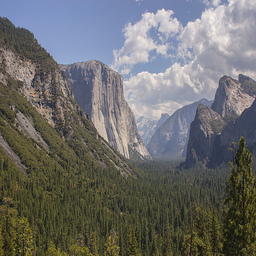

In [13]:
img = next(iter(test_loader))
img = img.to(device)
show_image(img)

In [8]:
from IPython.display import clear_output
import time
original_size = 16
# size = 20
h, w = 20, 28
codebook_size = 512
window_size = 16

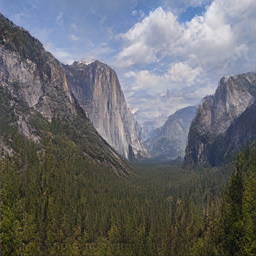

tensor(0.1269, device='cuda:0')
------------------


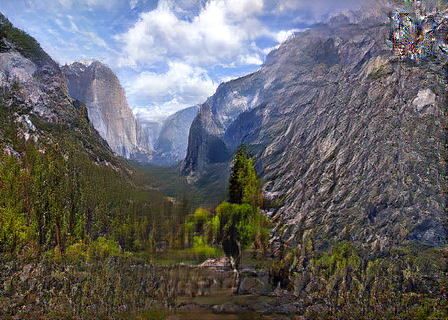

Time: 11.774888277053833 seconds
Step: (19,27) | Local: (15,15) | Crop: (4:20,12:28)


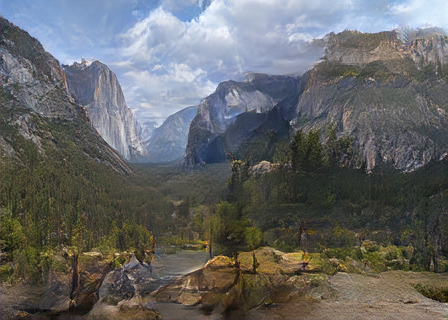

---------------------------------------------
Time: 11.243347406387329 seconds
Step: (19,27) | Local: (15,15) | Crop: (4:20,12:28)


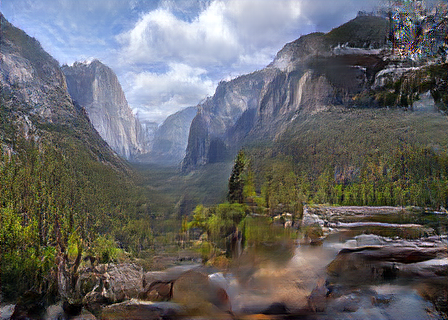

---------------------------------------------
Time: 11.799833297729492 seconds
Step: (19,27) | Local: (15,15) | Crop: (4:20,12:28)


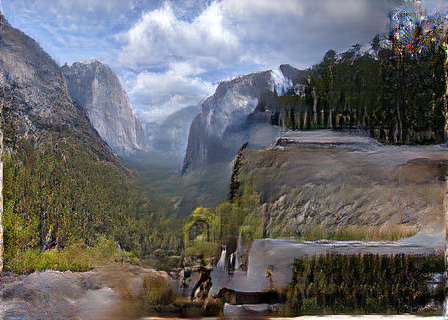

---------------------------------------------
Time: 11.764669179916382 seconds
Step: (19,27) | Local: (15,15) | Crop: (4:20,12:28)


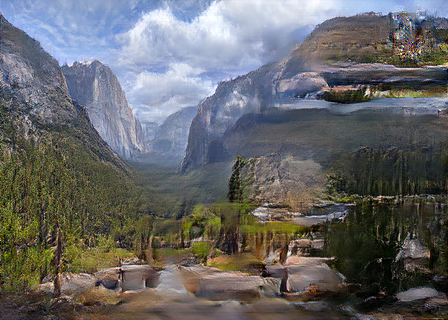

---------------------------------------------
Time: 11.768471956253052 seconds
Step: (19,27) | Local: (15,15) | Crop: (4:20,12:28)


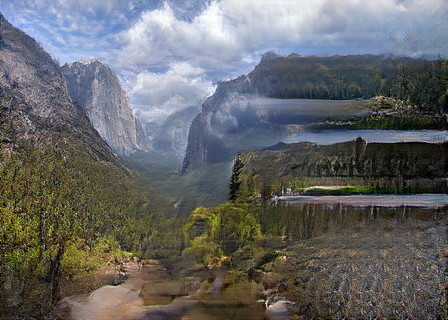

---------------------------------------------
torch.Size([1, 3, 320, 448])


In [60]:
label = 1

z_code, z_indices, style = model.encode_to_z(img, 1) # [1, 256]
# z_code_shape = (1, codebook_size,  size, size)
z_code_shape = (1, codebook_size,  h, w)
z_indices_shape = z_indices.shape


style = model.first_stage_model.encode_style(img, label)
x_sample = model.decode_to_img(
    z_indices.reshape(z_code_shape[0], original_size, original_size), 
    (z_code_shape[0], codebook_size, original_size, original_size), style, label)
show_image(x_sample)

print(nn.L1Loss()(img, x_sample))
print('------------------')


z_random = torch.randint(codebook_size, (w*h,)).to(device) # [400]
z_random = z_random.reshape(z_code_shape[0], h, w) # [1, 20, 20]

# # set left-top part as the input image
z_random[:, :original_size, :original_size] = z_indices.reshape(z_code_shape[0], original_size, original_size)

## idx as the input (original + random)
idx = z_random.detach().clone() # [1, 20, 20]

# print(z_indices.reshape(-1) == z_random[:, :original_size, :original_size].reshape(-1))
x_sample = model.decode_to_img(idx, z_code_shape, style, label)
show_image(x_sample)

# print('------------------')



# coordinate encode as condition
c_size = 256 # original image size
coordinate = np.arange(c_size*c_size).reshape(c_size,c_size,1)/(c_size*c_size)
coordinate = torch.from_numpy(coordinate) # [256, 256, 1]
c = model.get_c(coordinate) # [1, 1, 256, 256]
c = c.to(device)


# encode with condition
_, cidx = model.encode_to_c(c) # [1, 256]
cidx = cidx.reshape(z_code_shape[0], 16, 16) # [1, 16, 16]


sample_num = 5
x_samples = []
for i in range(sample_num):
    gen_img = sythesize(idx, style, label=label, z_code_shape=z_code_shape, temperature=1.4, top_k=150)
    x_samples.append(gen_img)

    # clear_output()
    show_image(gen_img)
    print('---------------------------------------------')
print(x_sample.shape)

---
### Winter

In [11]:
from IPython.display import clear_output
import time

# root = '/home/jenny870207/data/{}'.format(dataset)
validation_data = dataset_single(root, 'test', 'B', 256, 256, flip=False)
test_loader2 = DataLoader(validation_data, batch_size=1, shuffle=True, pin_memory=True)

style source


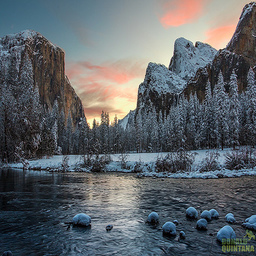

In [12]:
img2 = next(iter(test_loader2))
img2 = img2.to(device)
print('style source')
show_image(img2)

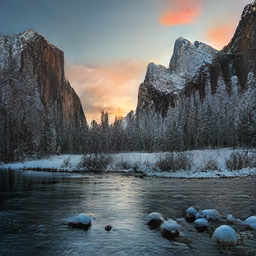

tensor(0.1349, device='cuda:0')
------------------


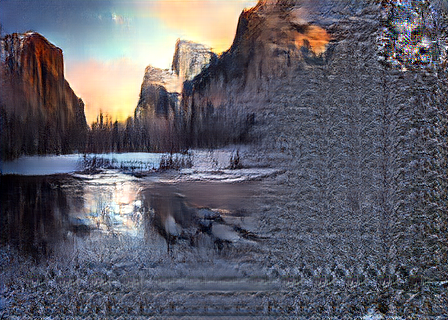

(1, 512, 20, 28)
Time: 7.892388343811035 seconds
Step: (19,27) | Local: (15,15) | Crop: (4:20,12:28)


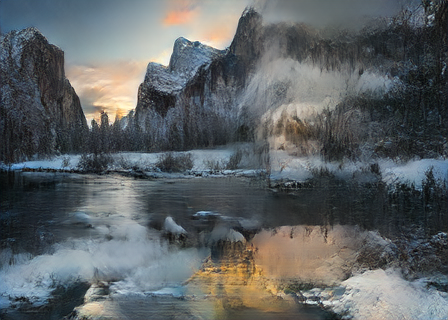

---------------------------------------------
(1, 512, 20, 28)
Time: 8.663388013839722 seconds
Step: (19,27) | Local: (15,15) | Crop: (4:20,12:28)


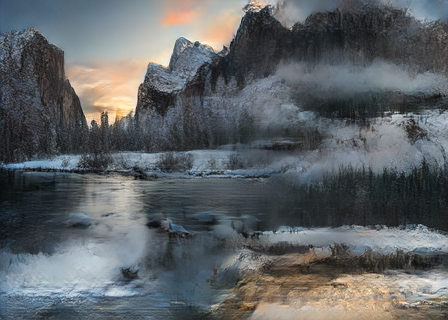

---------------------------------------------
(1, 512, 20, 28)
Time: 7.75429368019104 seconds
Step: (19,27) | Local: (15,15) | Crop: (4:20,12:28)


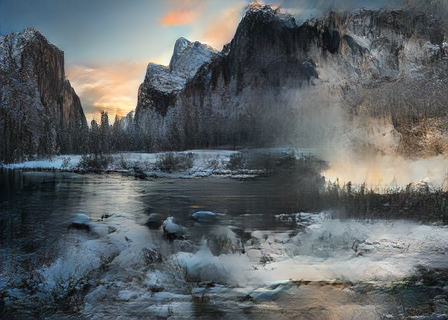

---------------------------------------------
(1, 512, 20, 28)
Time: 7.752455711364746 seconds
Step: (19,27) | Local: (15,15) | Crop: (4:20,12:28)


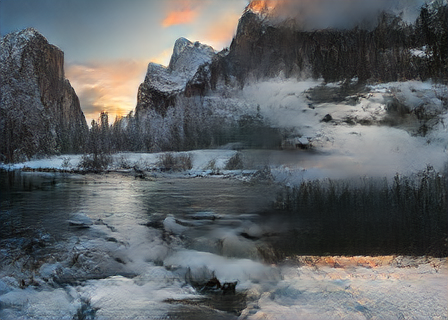

---------------------------------------------
(1, 512, 20, 28)
Time: 9.425915479660034 seconds
Step: (19,27) | Local: (15,15) | Crop: (4:20,12:28)


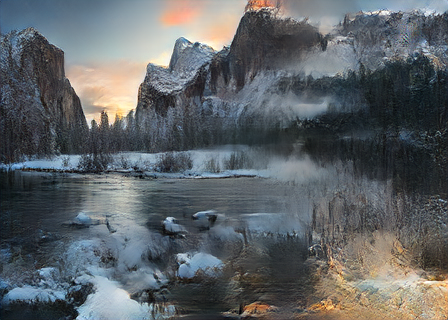

---------------------------------------------
torch.Size([1, 3, 320, 448])


In [15]:
label = 0

z_code, z_indices, style = model.encode_to_z(img2, 1) # [1, 256]
# z_code_shape = (1, codebook_size,  size, size)
z_code_shape = (1, codebook_size,  h, w)
z_indices_shape = z_indices.shape


style = model.first_stage_model.encode_style(img2, label)
x_sample = model.decode_to_img(
    z_indices.reshape(z_code_shape[0], original_size, original_size), 
    (z_code_shape[0], codebook_size, original_size, original_size), style, label)
show_image(x_sample)

print(nn.L1Loss()(img2, x_sample))
print('------------------')


z_random = torch.randint(codebook_size, (w*h,)).to(device) # [400]
z_random = z_random.reshape(z_code_shape[0], h, w) # [1, 20, 20]

# # set left-top part as the input image
z_random[:, :original_size, :original_size] = z_indices.reshape(z_code_shape[0], original_size, original_size)

## idx as the input (original + random)
idx = z_random.detach().clone() # [1, 20, 20]

# print(z_indices.reshape(-1) == z_random[:, :original_size, :original_size].reshape(-1))
x_sample = model.decode_to_img(idx, z_code_shape, style, label)
show_image(x_sample)

# print('------------------')



# coordinate encode as condition
c_size = 256 # original image size
coordinate = np.arange(c_size*c_size).reshape(c_size,c_size,1)/(c_size*c_size)
coordinate = torch.from_numpy(coordinate) # [256, 256, 1]
c = model.get_c(coordinate) # [1, 1, 256, 256]
c = c.to(device)


# encode with condition
_, cidx = model.encode_to_c(c) # [1, 256]
cidx = cidx.reshape(z_code_shape[0], 16, 16) # [1, 16, 16]


sample_num = 5
x_samples = []
for i in range(sample_num):
    gen_img = sythesize(idx, style, label=label, z_code_shape=z_code_shape, temperature=2.0, top_k=120)
    x_samples.append(gen_img)

    # clear_output()
    show_image(gen_img)
    print('---------------------------------------------')
print(x_sample.shape)

---